# Amazon Fine Food Reviews Analysis - Classification using LSTM


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

# from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
np.random.seed(7)

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

warnings.filterwarnings("ignore")
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('drive/My Drive/AmazonFineFoodReviews/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"ain\'t", "is not", phrase)
    phrase = re.sub(r"gonna", "going to", phrase)
    phrase = re.sub(r"gotta", "got to", phrase)
    phrase = re.sub(r"\'cause", "because", phrase)
    
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great flavor low in calories high in nutrients high in protein Usually protein powders are high priced and high in calories this one is a great bargain and tastes great I highly recommend for the lady gym rats probably not macho enough for guys since it is soy based 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    # Not removing stopwords to preserve sequence info
    sentence = ' '.join(e.lower() for e in sentence.split()) #if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())

100%|██████████| 46071/46071 [00:15<00:00, 2999.11it/s]


In [24]:
preprocessed_reviews[1500]

'great flavor low in calories high in nutrients high in protein usually protein powders are high priced and high in calories this one is a great bargain and tastes great i highly recommend for the lady gym rats probably not macho enough for guys since it is soy based'

In [0]:
preprocessed_reviews_test = preprocessed_reviews[35000:]
y_test = final['Score'][35000:]
preprocessed_reviews_train = preprocessed_reviews[:35000]
y_train = final['Score'][:35000]

In [26]:
print("No. of reviews in Train Set: ", len(preprocessed_reviews_train))
print("No. of reviews in Test Set: ", len(preprocessed_reviews_test))
print("Test size as a percentage of the datatset: ", 
      len(preprocessed_reviews_test)*100/(len(preprocessed_reviews_train) + len(preprocessed_reviews_test)))

No. of reviews in Train Set:  35000
No. of reviews in Test Set:  11071
Test size as a percentage of the datatset:  24.030301057064097


# [4] Converting Reviews into Sequences of Integer Indices

## [4.1] BAG OF WORDS Featurization of Review Corpus

In [27]:
#BoW
top_words = 5000
count_vect = CountVectorizer(max_features=top_words) #in scikit-learn
count_vect.fit(preprocessed_reviews_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews_train)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['ability', 'able', 'about', 'above', 'absolute', 'absolutely', 'absorb', 'absorbed', 'acai', 'accept']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (35000, 5000)
the number of unique words  5000


## [4.2] Generating Sequence of Integers for each Review using Vocabulary of Train Set

In [28]:
X_train = []; X_test = []
vocab = count_vect.vocabulary_
# Turning all reviews in Train and Test sets into sequence of integers(word indexes in train set vocabulary)
for sent in tqdm(preprocessed_reviews_train):
    sent = [vocab[word] for word in sent.split() if word in vocab.keys()]
    X_train.append(sent)

for sent in tqdm(preprocessed_reviews_test):
    sent = [vocab[word] for word in sent.split() if word in vocab.keys()]
    X_test.append(sent)

100%|██████████| 11071/11071 [00:00<00:00, 41229.10it/s]


In [29]:
max_review_length = max([len(sent) for sent in X_train+X_test])
print("Length of longest review: ", max_review_length)
# Padding Train and Test Set reviews with zeros
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

Length of longest review:  1410
(35000, 1410)
[   0    0    0 ... 4468 4852 3705]


In [30]:
y_train.value_counts(normalize=True)

1    0.838029
0    0.161971
Name: Score, dtype: float64

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

# [5] Building and Training an LSTM model

## [5.1] Model 1

In [39]:
# create the model
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(top_words+1, embedding_vector_length, input_length=max_review_length))
model.add(LSTM(35, dropout=0.5, kernel_initializer='glorot_normal'))
#model.add(LSTM(100))
#model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1410, 32)          160032    
_________________________________________________________________
lstm_4 (LSTM)                (None, 35)                9520      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 36        
Total params: 169,588
Trainable params: 169,588
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
# Since there are nearly 5 times positive class samples than negative, we are balancing class weights as 5:1
history = model.fit(X_train, y_train, nb_epoch=10, batch_size=500, verbose=1,
                   validation_data=(X_test, y_test), class_weight={0:5, 1:1})
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
with open('history.pkl', 'wb') as hfile:
  pickle.dump(history, hfile)

Train on 35000 samples, validate on 11071 samples
Epoch 1/10
35000/35000 [==============================] - 181s 5ms/step - loss: 1.0072 - acc: 0.7209 - val_loss: 0.4591 - val_acc: 0.8014
Epoch 2/10
35000/35000 [==============================] - 177s 5ms/step - loss: 0.5843 - acc: 0.8461 - val_loss: 0.3554 - val_acc: 0.8387
Epoch 3/10
35000/35000 [==============================] - 179s 5ms/step - loss: 0.4532 - acc: 0.8868 - val_loss: 0.2961 - val_acc: 0.8802
Epoch 4/10
35000/35000 [==============================] - 178s 5ms/step - loss: 0.4090 - acc: 0.8991 - val_loss: 0.2994 - val_acc: 0.8751
Epoch 5/10
35000/35000 [==============================] - 177s 5ms/step - loss: 0.3559 - acc: 0.9144 - val_loss: 0.3069 - val_acc: 0.8775
Epoch 6/10
35000/35000 [==============================] - 178s 5ms/step - loss: 0.3323 - acc: 0.9182 - val_loss: 0.3433 - val_acc: 0.8663
Epoch 7/10
35000/35000 [==============================] - 176s 5ms/step - loss: 0.3099 - acc: 0.9247 - val_loss: 0.3320 - 

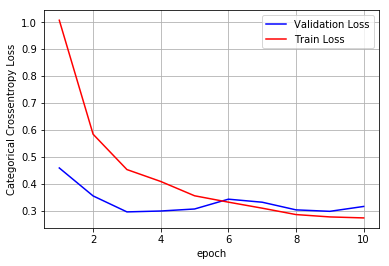

In [41]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1, 10+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

## [5.2] Model 2

In [0]:
from keras.layers import Bidirectional
#top_words = 5000;max_review_length = 2073
# create the model
embedding_vector_length = 32
model2 = Sequential()
model2.add(Embedding(top_words+1, embedding_vector_length, input_length=max_review_length))
model2.add(Bidirectional(LSTM(40, dropout=0.7, recurrent_dropout=0.1, return_sequences=True, kernel_initializer='glorot_normal')))
model2.add(LSTM(40, dropout=0.5, kernel_initializer='glorot_normal'))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1410, 32)          160032    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 1410, 80)          23360     
_________________________________________________________________
lstm_12 (LSTM)               (None, 40)                19360     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 41        
Total params: 202,793
Trainable params: 202,793
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history2 = model2.fit(X_train, y_train, nb_epoch=10, batch_size=500, verbose=1,
                   validation_data=(X_test, y_test), class_weight={0:5, 1:1})
# Final evaluation of the model
scores2 = model2.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores2[1]*100))
with open('history2.pkl', 'wb') as hfile:
  pickle.dump(history2, hfile)

Instructions for updating:
Use tf.cast instead.
Train on 35000 samples, validate on 11071 samples
Epoch 1/10
35000/35000 [==============================] - 717s 20ms/step - loss: 1.0044 - acc: 0.7437 - val_loss: 0.3622 - val_acc: 0.8506
Epoch 2/10
35000/35000 [==============================] - 718s 21ms/step - loss: 0.6391 - acc: 0.8352 - val_loss: 0.3445 - val_acc: 0.8520
Epoch 3/10
35000/35000 [==============================] - 714s 20ms/step - loss: 0.4997 - acc: 0.8774 - val_loss: 0.3109 - val_acc: 0.8735
Epoch 4/10
35000/35000 [==============================] - 718s 21ms/step - loss: 0.4503 - acc: 0.8904 - val_loss: 0.2897 - val_acc: 0.8810
Epoch 5/10
35000/35000 [==============================] - 717s 20ms/step - loss: 0.4063 - acc: 0.9032 - val_loss: 0.2997 - val_acc: 0.8707
Epoch 6/10
35000/35000 [==============================] - 709s 20ms/step - loss: 0.3822 - acc: 0.9065 - val_loss: 0.3305 - val_acc: 0.8623
Epoch 7/10
35000/35000 [==============================] - 707s 20ms/

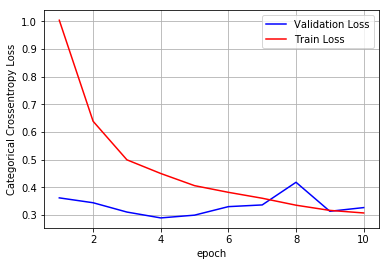

In [0]:
with open('history2.pkl', 'rb') as hfile:
  history2 = pickle.load(hfile)
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1, 10+1))

vy = history2.history['val_loss']
ty = history2.history['loss']
plt_dynamic(x, vy, ty, ax)

## [5.3] Model 3

In [42]:
# create the model
embedding_vector_length = 64
model3 = Sequential()
model3.add(Embedding(top_words+1, embedding_vector_length, input_length=max_review_length))
model3.add(LSTM(60, return_sequences=True, dropout=0.6))
model3.add(LSTM(30, dropout=0.5))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model3.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1410, 64)          320064    
_________________________________________________________________
lstm_5 (LSTM)                (None, 1410, 60)          30000     
_________________________________________________________________
lstm_6 (LSTM)                (None, 30)                10920     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 31        
Total params: 361,015
Trainable params: 361,015
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
history3 = model3.fit(X_train, y_train, nb_epoch=10, batch_size=500, verbose=1, 
                      validation_data=(X_test, y_test), class_weight={0: 5, 1: 1})
# Final evaluation of the model
scores3 = model3.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores3[1]*100))
with open('history3.pkl', 'wb') as hfile:
  pickle.dump(history3, hfile)

Train on 35000 samples, validate on 11071 samples
Epoch 1/10
35000/35000 [==============================] - 356s 10ms/step - loss: 0.9601 - acc: 0.7707 - val_loss: 0.4412 - val_acc: 0.8035
Epoch 2/10
35000/35000 [==============================] - 357s 10ms/step - loss: 0.5798 - acc: 0.8510 - val_loss: 0.2812 - val_acc: 0.8827
Epoch 3/10
35000/35000 [==============================] - 354s 10ms/step - loss: 0.4704 - acc: 0.8851 - val_loss: 0.3105 - val_acc: 0.8685
Epoch 4/10
35000/35000 [==============================] - 355s 10ms/step - loss: 0.4059 - acc: 0.9016 - val_loss: 0.3149 - val_acc: 0.8708
Epoch 5/10
35000/35000 [==============================] - 353s 10ms/step - loss: 0.3694 - acc: 0.9105 - val_loss: 0.3027 - val_acc: 0.8826
Epoch 6/10
35000/35000 [==============================] - 351s 10ms/step - loss: 0.3746 - acc: 0.9085 - val_loss: 0.3578 - val_acc: 0.8419
Epoch 7/10
35000/35000 [==============================] - 352s 10ms/step - loss: 0.3494 - acc: 0.9117 - val_loss: 0.

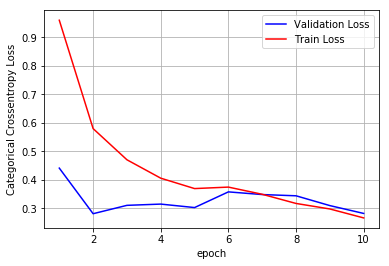

In [44]:
with open('history3.pkl', 'rb') as hfile:
  history3 = pickle.load(hfile)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
# list of epoch numbers
x = list(range(1, 10+1))

vy = history3.history['val_loss']
ty = history3.history['loss']
plt_dynamic(x, vy, ty, ax)

# [6] Conclusion

In [9]:
from prettytable import PrettyTable
x = PrettyTable(field_names=[" ", "Model Architecture", "LSTM Dropout", "Train Loss", "Test Loss", "Train Accuracy", 
                             "Test Accuracy"])
x.add_row(["1", 
'''
_______________________________________________________
Layer (type)            Output Shape       Param #   
=======================================================
embedding_4 (Embedding) (None, 1410, 32)    160032    
_______________________________________________________
lstm_4 (LSTM)           (None, 35)          9520      
_______________________________________________________
dense_4 (Dense)         (None, 1)      36        
=======================================================
Total params: 169,588
Trainable params: 169,588
Non-trainable params: 0
_______________________________________________________''', "\n\n\n\n\n\n0.5" , "\n\n\n\n\n\n0.2738", "\n\n\n\n\n\n0.3163", 
           "\n\n\n\n\n\n93.33%", "\n\n\n\n\n\n88.23%"
])
x.add_row(["===", "=======================================================", "======","======", "======", "======","======"])
x.add_row(["2", '''
Layer (type)            Output Shape        Param #   
=======================================================
embedding_3 (Embedding) (None, 1410, 32)    160032    
_______________________________________________________
bidirectional_6
(Bidirectional LSTM)    (None, 1410, 80)    23360     
_______________________________________________________
lstm_12 (LSTM)          (None, 40)          19360     
_______________________________________________________
dense_6 (Dense)         (None, 1)           41        
=======================================================
Total params: 202,793
Trainable params: 202,793
Non-trainable params: 0
_______________________________________________________''', '''\n\n\n\n\n\n0.7\n\n\n0.5''', "\n\n\n\n\n0.3076", 
           "\n\n\n\n\n0.3270", "\n\n\n\n\n92.55%", "\n\n\n\n\n87.08%"])
x.add_row(["===", "=======================================================", "======", "======","======","======","======"])
x.add_row(["3", '''
Layer (type)            Output Shape        Param #   
=======================================================
embedding_5 (Embedding) (None, 1410, 64)    320064    
_______________________________________________________
lstm_5 (LSTM)           (None, 1410, 60)    30000     
_______________________________________________________
lstm_6 (LSTM)           (None, 30)          10920     
_______________________________________________________
dense_5 (Dense)         (None, 1)           31        
=======================================================
Total params: 361,015
Trainable params: 361,015
Non-trainable params: 0''', '''\n\n\n\n\n0.6\n\n0.5''', "\n\n\n\n\n0.2664", "\n\n\n\n\n0.2821", 
           "\n\n\n\n\n93.47%", "\n\n\n\n\n89.45%"])

x.padding_width = 0
print(x)

+---+-------------------------------------------------------+------------+----------+---------+--------------+-------------+
|   |                   Model Architecture                  |LSTM Dropout|Train Loss|Test Loss|Train Accuracy|Test Accuracy|
+---+-------------------------------------------------------+------------+----------+---------+--------------+-------------+
| 1 |                                                       |            |          |         |              |             |
|   |_______________________________________________________|            |          |         |              |             |
|   | Layer (type)            Output Shape       Param #    |            |          |         |              |             |
|   |=======================================================|            |          |         |              |             |
|   | embedding_4 (Embedding) (None, 1410, 32)    160032    |            |          |         |              |             |
